In [1]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer, recall_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 40)

In [2]:
df = pd.read_csv('credit_ds.csv', low_memory=False)

In [3]:
df.drop(columns=["Credit_Score_Label", "ID", "Customer_ID", "Name", "SSN"], inplace=True)

In [4]:
df.shape

(94123, 24)

In [5]:
### Feature Engineering of Categorical columns

# Define the mapping for ordinal encoding
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

# Apply the mapping to the Month column
df['Month'] = df['Month'].map(month_mapping)

# One-hot encode the Occupation column
df = pd.get_dummies(df, columns=['Occupation'], prefix='Occupation')

# Step 1: Encode `Credit_Mix` (Ordinal Encoding)
credit_mix_mapping = {'Good': 3, 'Standard': 2, 'Bad': 1}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_mapping)

# Step 2: Encode `Payment_of_Min_Amount` (Binary Encoding)
payment_min_mapping = {'Yes': 1, 'No': 0}
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(payment_min_mapping)

# Step 3: Encode `Payment_Behaviour` (Ordinal Encoding)
payment_mapping = {
    'High_spent_Large_value_payments': 6,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Small_value_payments': 4,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Small_value_payments': 1
}
df['Payment_Behaviour'] = df['Payment_Behaviour'].map(payment_mapping)

# Step 4: Process `Type_of_Loan`
# Define unique loan types
unique_loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 
    'Home Equity Loan', 'Mortgage Loan', 'No Loan', 
    'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# Add a new column for each unique loan type
for loan_type in unique_loan_types:
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()
    df[cleaned_loan_type] = df['Type_of_Loan'].apply(lambda x: x.count(loan_type) if isinstance(x, str) else 0)

# Drop the original `Type_of_Loan` column
df = df.drop(columns=['Type_of_Loan'], errors='ignore')

# Verify the resulting dataset
print("Final Dataset Shape After Encoding:", df.shape)

Final Dataset Shape After Encoding: (94123, 47)


In [6]:
# Modeling the data

# Separate features and target
X = df.drop(columns=['Credit_Score'])  # Assuming 'Credit_Score' is your target
y = df['Credit_Score']

# Split the dataset into training and testing sets (75:25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# List of skewed numerical features identified earlier
skewed_features = ['Annual_Income', 'Monthly_Inhand_Salary','Outstanding_Debt', 'Total_EMI_per_month','Monthly_Balance', 'Amount_invested_monthly']

# Initialize PowerTransformer for skewed features
pt = PowerTransformer(method='yeo-johnson')

# Apply PowerTransformer only on the training set, then transform the test set using the same parameters
X_train[skewed_features] = pt.fit_transform(X_train[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Initialize StandardScaler for scaling
scaler = StandardScaler()

# Apply scaling to the entire training set, then transform the test set using the same parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrames for usability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


## hyper-parameter tuning

In [7]:

# Define StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define parameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Extra Trees model
etc = ExtraTreesClassifier(random_state=42, class_weight="balanced")

# # Custom scoring function for recall of the "Poor" class
# scorer = make_scorer(recall_score, average=None, labels=[0])  # Assuming "Poor" is class 0

# Custom multi-metric scoring for "Poor" class recall and macro recall
def custom_score(y_true, y_pred):
    poor_recall = recall_score(y_true, y_pred, average=None)[0]  # Recall for "Poor" class
    macro_recall = recall_score(y_true, y_pred, average='macro')  # Macro-average recall
    return (poor_recall + macro_recall) / 2  # Combine metrics

custom_scorer = make_scorer(custom_score)

# RandomizedSearchCV with StratifiedKFold
random_search = RandomizedSearchCV(
    estimator=etc,
    param_distributions=param_dist,
    n_iter=50,
    scoring=custom_scorer,
    cv=cv,  # Use StratifiedKFold here
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train_scaled_df, y_train)

# Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Recall for 'Poor' Class:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   4.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  23.4s


/Users/rahuldev/miniforge3/envs/big_data/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   4.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  42.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  42.4s
[CV] END bootstrap=False, max_depth=10, min_samples_l

Evaluating Extra Trees...


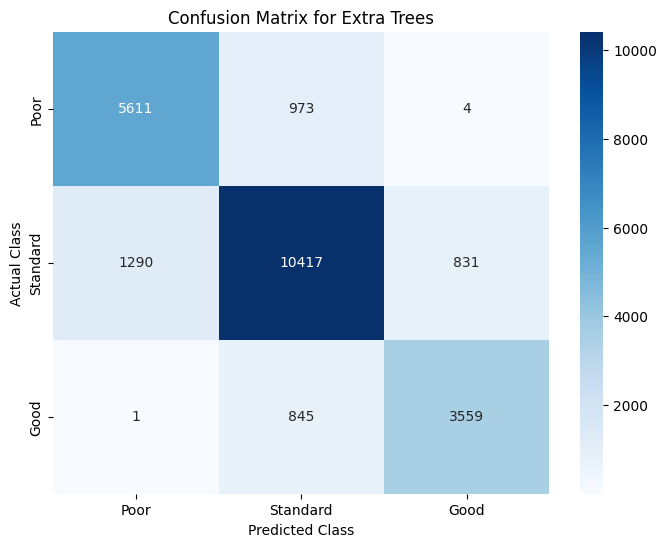

Classification Report for Extra Trees:
              precision    recall  f1-score   support

        Poor       0.81      0.85      0.83      6588
    Standard       0.85      0.83      0.84     12538
        Good       0.81      0.81      0.81      4405

    accuracy                           0.83     23531
   macro avg       0.82      0.83      0.83     23531
weighted avg       0.83      0.83      0.83     23531



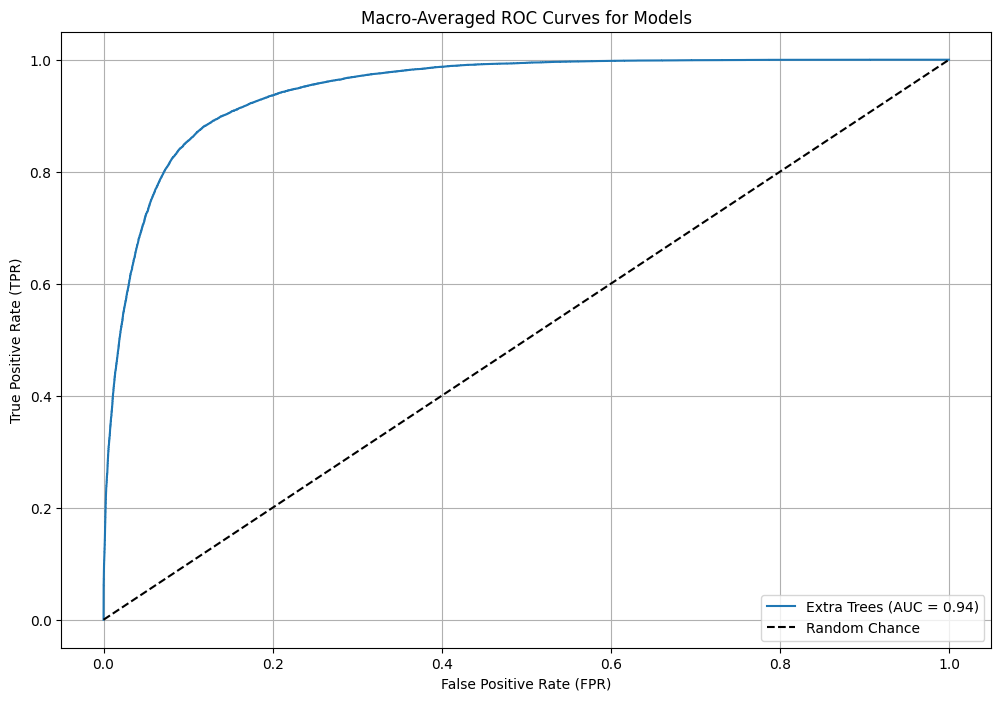

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  15.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  17.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  20.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  52.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  20.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  15.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   6.1s
[CV] END bootstrap=False, max_depth=None, min_sa

In [8]:

# Define models
models = {
    'Extra Trees': ExtraTreesClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=50, bootstrap=False,random_state=42, n_jobs=-1)
}

# Binarize the target (for multi-class ROC AUC)
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_train_bin.shape[1]

# Classes
classes = ['Poor', 'Standard', 'Good']

# Initialize a dictionary to store results
model_results = {}
roc_data = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    y_prob = model.predict_proba(X_test_scaled_df)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    model_results[model_name] = report

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig(f"Confusion Matrix for {model_name}.png", dpi=300)
    plt.show()
    plt.close()

    # Macro-Averaged AUC-ROC
    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    roc_data[model_name] = {"probabilities": y_prob, "macro_auc": macro_auc}

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=classes))

# Plot Macro-Averaged ROC Curve
plt.figure(figsize=(12, 8))
for model_name, data in roc_data.items():
    y_prob = data["probabilities"]
    macro_auc = data["macro_auc"]

    # Compute macro-average ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("macro_average_roc.png", dpi=300)
plt.show()
plt.close()

In [10]:
# Find the best model based on F1-score and recall for "Poor"
best_model_name = None
best_poor_f1 = 0
best_poor_recall = 0

for model_name, report in model_results.items():
    poor_f1 = report['Poor']['f1-score']
    poor_recall = report['Poor']['recall']
    print(f"{model_name} - F1 (Poor): {poor_f1:.2f}, Recall (Poor): {poor_recall:.2f}")

    if poor_f1 > best_poor_f1:
        best_poor_f1 = poor_f1
        best_poor_recall = poor_recall
        best_model_name = model_name

print(f"\nBest Model for 'Poor': {best_model_name} with F1 = {best_poor_f1:.2f}, Recall = {best_poor_recall:.2f}")


Extra Trees - F1 (Poor): 0.83, Recall (Poor): 0.85

Best Model for 'Poor': Extra Trees with F1 = 0.83, Recall = 0.85


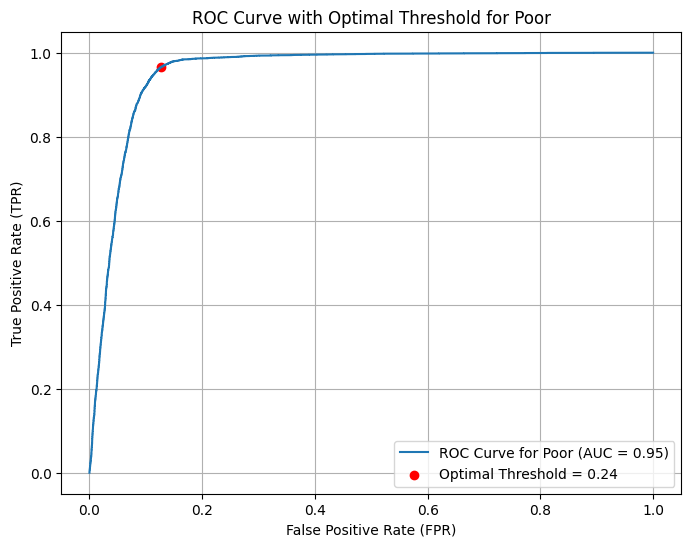

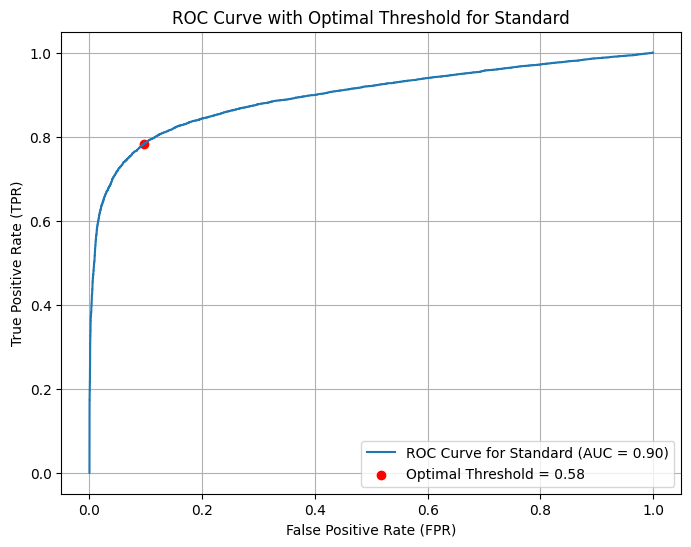

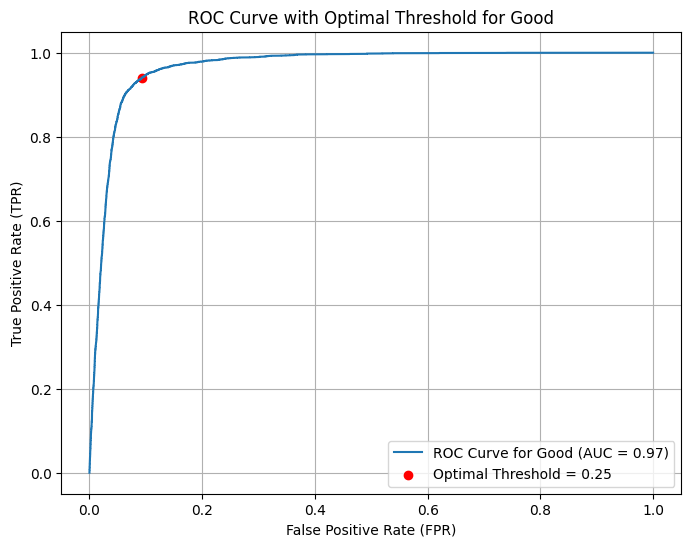

Optimal Thresholds for Each Class: {'Poor': np.float64(0.23568759584713525), 'Standard': np.float64(0.5754464285714288), 'Good': np.float64(0.25035498040532284)}
Debugging Metrics for 'Poor': TP=6361, FN=227, FP=2142, TN=14801
Recall (Poor): 0.9655, Precision (Poor): 0.7481, F1-Score (Poor): 0.8430
Classification Report (After Threshold Tuning):
              precision    recall  f1-score   support

        Poor       0.75      0.97      0.84      6588
    Standard       0.93      0.74      0.82     12538
        Good       0.78      0.88      0.82      4405

    accuracy                           0.83     23531
   macro avg       0.82      0.86      0.83     23531
weighted avg       0.85      0.83      0.83     23531

Confusion Matrix:
[[6361  212   15]
 [2134 9294 1110]
 [   8  515 3882]]
Manually Calculated Recall for 'Poor': 0.9655
Manually Calculated Precision for 'Poor': 0.7481


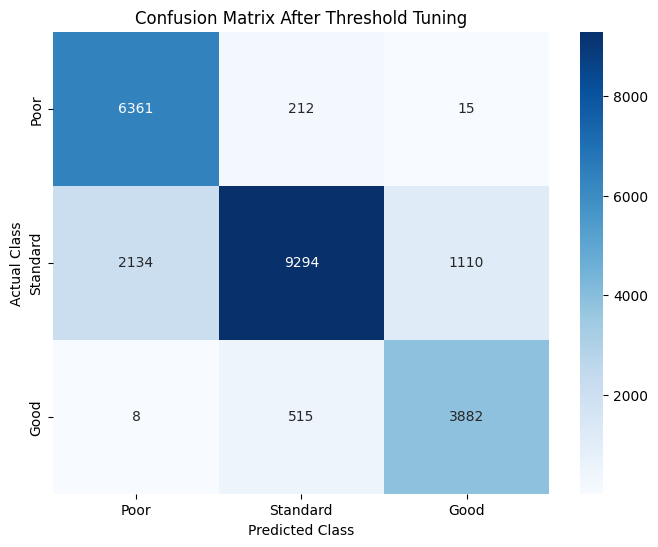

In [11]:
# Fit the best model and predict probabilities
best_model = models[best_model_name]
best_model.fit(X_train_scaled_df, y_train)

# Predict probabilities with the best model
y_prob = best_model.predict_proba(X_test_scaled_df)

# Tune thresholds for each class
optimal_thresholds = {}
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob[:, i])
    optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[cls] = optimal_threshold

    # Plot ROC curve with optimal threshold
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve for {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_prob[:, i]):.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve with Optimal Threshold for {cls}')
    plt.legend()
    plt.grid()
    plt.savefig(f"ROC Curve - {cls}.png", dpi=300)
    plt.show()
    plt.close()

print("Optimal Thresholds for Each Class:", optimal_thresholds)

# Apply the tuned thresholds to make predictions
y_pred_tuned = []
for i in range(len(X_test_scaled_df)):
    class_probs = y_prob[i]
    assigned_class = None
    for cls_idx, cls in enumerate(classes):
        if class_probs[cls_idx] >= optimal_thresholds[cls]:
            assigned_class = cls_idx
            break
    if assigned_class is None:
        assigned_class = np.argmax(class_probs)  # Default to the highest probability class
    y_pred_tuned.append(assigned_class)

# Debugging Step: Recalculate Confusion Matrix Metrics for "Poor"
tp_poor = sum((np.array(y_pred_tuned) == 0) & (y_test == 0))
fn_poor = sum((np.array(y_pred_tuned) != 0) & (y_test == 0))
fp_poor = sum((np.array(y_pred_tuned) == 0) & (y_test != 0))
tn_poor = sum((np.array(y_pred_tuned) != 0) & (y_test != 0))

recall_poor_debug = tp_poor / (tp_poor + fn_poor)
precision_poor_debug = tp_poor / (tp_poor + fp_poor)
f1_poor_debug = 2 * (precision_poor_debug * recall_poor_debug) / (precision_poor_debug + recall_poor_debug)

print(f"Debugging Metrics for 'Poor': TP={tp_poor}, FN={fn_poor}, FP={fp_poor}, TN={tn_poor}")
print(f"Recall (Poor): {recall_poor_debug:.4f}, Precision (Poor): {precision_poor_debug:.4f}, F1-Score (Poor): {f1_poor_debug:.4f}")

# Confusion Matrix and Classification Report after Threshold Tuning
print("Classification Report (After Threshold Tuning):")
print(classification_report(y_test, y_pred_tuned, target_names=classes))

cm = confusion_matrix(y_test, y_pred_tuned, labels=[0, 1, 2])

# Double-check metrics derived from the confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"Manually Calculated Recall for 'Poor': {cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2]):.4f}")
print(f"Manually Calculated Precision for 'Poor': {cm[0, 0] / (cm[0, 0] + cm[1, 0] + cm[2, 0]):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix After Threshold Tuning")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("Confusion Matrix After Threshold Tuning.png", dpi=300)
plt.show()
plt.close()


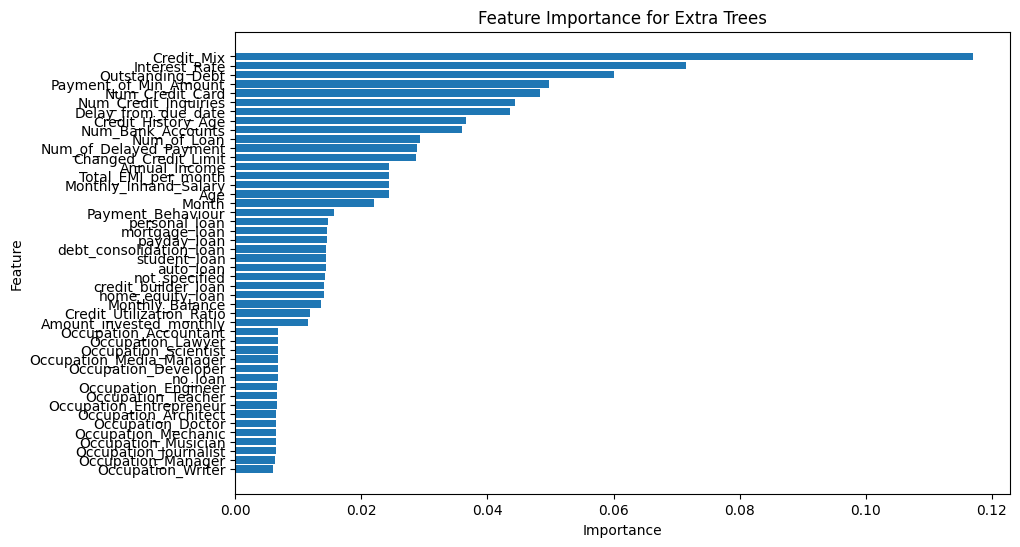

In [12]:
# Assuming best_model is your chosen Extra Trees model
feature_importances = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Extra Trees')
plt.gca().invert_yaxis()
plt.show()
